<a href="https://colab.research.google.com/github/amarviswanathan/AppliedDataScience/blob/master/CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#COS 485 ConvNets at Scale
The source is based on https://github.com/kuangliu/pytorch-cifar

# Load Pytorch
To run on the GPU choose Runtime > Change Runtime Type > Hardware Accelerator -> GPU

In [ ]:
# http://pytorch.org/
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.0.post4-{platform}-linux_x86_64.whl torchvision

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable
import torchvision.transforms as transforms
from IPython import display

In [ ]:
use_cuda = torch.cuda.is_available()

Visualizations

In [ ]:
from IPython.display import display, clear_output
    
# accuracy/loss plotting helper function
def plot_learning(plot_handles, ylabel):
    plt.legend(handles=plot_handles, loc="center right")
    plt.xlabel("Epochs")
    plt.ylabel(ylabel)

def plot(step, train_acc, val_acc, train_loss, val_loss, x, y, pred):
    clear_output(wait=False)
    plt.gcf().clear()
    plt.subplot(1,4,1)
    train_plot, = plt.plot(range(display_step,step+1,display_step), train_acc[:int(step/display_step)], 'r', label="training")
    val_plot, = plt.plot(range(display_step,step+1,display_step), val_acc[:int(step/display_step)], 'b', label="validation")
    plot_learning([train_plot, val_plot], "Accuracy")
    plt.title("Classification accuracy")

    plt.subplot(1,4,2)
    train_plot, = plt.plot(range(display_step,step+1,display_step), train_loss[:int(step/display_step)], 'r', label="training")
    val_plot, = plt.plot(range(display_step,step+1,display_step), val_loss[:int(step/display_step)], 'b', label="validation")
    plot_learning([train_plot, val_plot], "Loss")
    plt.title("Cross entropy loss")

    plt.subplot(1,4,3)
    x = (x-x.min())
    x /= x.max() 
    plt.imshow(x, interpolation='nearest')
    plt.title("Input image")
    plt.xlabel("true label: " + categories[y[0]])

    plt.subplot(1,4,4)
    plt.bar(np.arange(0,len(pred),1), pred)
    plt.title("Class probabilities")
    plt.xticks(np.arange(0.5,len(categories),1), categories, rotation="vertical")

    plt.gcf().set_size_inches(18, 3.5)
    display(plt.gcf())
    

# Dataset
Download CIFAR, preprocess and Display some examples

In [ ]:
# Preprocessing step
transform_train = transforms.Compose([
    #Augmentations go here
    #transforms.RandomCrop(32, padding=4),
    #transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [ ]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

Files already downloaded and verified


Data shape: (50000, 32, 32, 3)
Labels shape: 50000


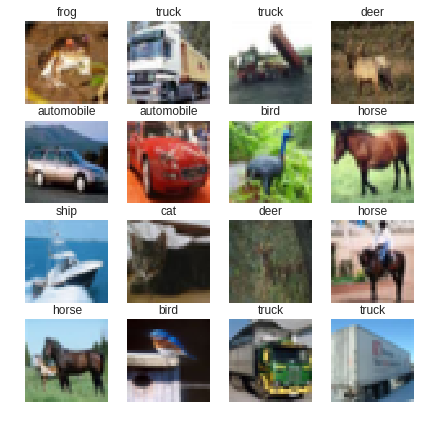

In [ ]:
print("Data shape: {}".format(trainset.train_data.shape))
print("Labels shape: {}".format(len(trainset.train_labels)))
categories = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(trainset.train_data[i], interpolation='nearest')
    label = trainset.train_labels[i]
    plt.title(categories[label])
    plt.axis('off')
plt.gcf().set_size_inches(7,7)

# Hyperparameters

In [ ]:
# Parameters
learning_rate = 0.001
training_epochs = 200
display_step = 1



#Network
It is useful to build the network as a class. Initialize the layers in __init__ function call when the object is created. Use forward for defining the forward pass. Then create the network, define the loss function and choose the optimizer.

In [ ]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1   = nn.Linear(16*5*5, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 10)
        
    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.max_pool2d(out, 2)
        out = F.relu(self.conv2(out))
        out = F.max_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out


In [ ]:
net = LeNet()

# Loss
criterion = nn.CrossEntropyLoss()

# Optimizer e.g. SGD, ADAM etc.
optimizer = optim.Adam(net.parameters(), lr=learning_rate)


In [ ]:
if use_cuda:
    print('using GPU')
    net.cuda()
    net = torch.nn.DataParallel(net, device_ids=range(torch.cuda.device_count()))
    cudnn.benchmark = True

using GPU


## Training

Training has three major steps
1. Forward pass defined by the network architecture. 
2. The backward pass computed by autodifferentiation of the forward pass
3. Weight update defined by the optimizer

In [ ]:
def train(epoch):
    net.train()
    train_loss = correct = total = batched = 0
    
    for i, (inputs, targets) in enumerate(trainloader):
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        optimizer.zero_grad()
        inputs, targets = Variable(inputs), Variable(targets)
        
        # Forward Pass
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        
        # Backward Pass
        loss.backward()
        
        # Update weights
        optimizer.step()

        train_loss += loss.data[0]
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()    
        batched += 1
    return train_loss/batched, correct, total
        

In [ ]:
softmax = torch.nn.Softmax()
def test(epoch):
    net.eval()
    test_loss = correct = total = batched = 0
    for batch_idx, (inputs, targets) in enumerate(testloader):
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        inputs, targets = Variable(inputs, volatile=True), Variable(targets)
        
        # Forward
        outputs = net(inputs)
        loss = criterion(outputs, targets)

        test_loss += loss.data[0]
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()
        outputs =  softmax(outputs)
        batched += 1
        
        if use_cuda:
          sample, target, label = inputs[0].permute(1,2,0).cpu().data.numpy(), targets[0].cpu().data.numpy(), outputs[0].cpu().data.numpy()
        else: 
          sample, target, label = inputs[0].permute(1,2,0).data.numpy(), targets[0].data.numpy(), outputs[0].data.numpy()
    return test_loss/batched, correct, total, sample, target, label


Main loop

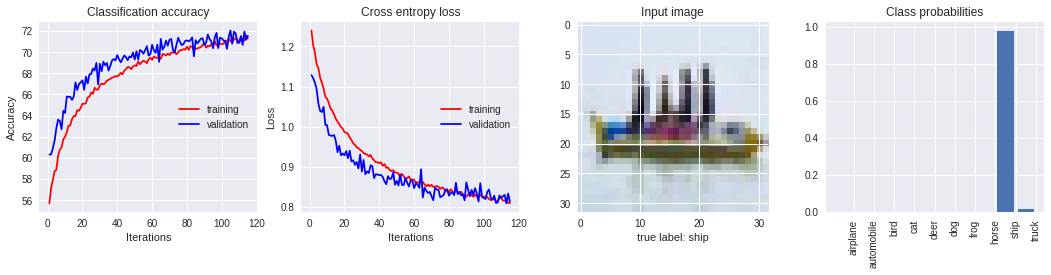

epoch:  116


In [ ]:
start_epoch = 0
train_acc, val_acc, train_loss, val_loss = [np.zeros(int(training_epochs)) for i in range(4)]
for epoch in range(start_epoch, start_epoch+training_epochs):
    print('epoch: ', epoch)
    tr_loss, tr_corr, tr_tot = train(epoch)
    vl_loss, vl_corr, vl_tot, sample, target, label = test(epoch)
    
    train_acc[epoch] = 100.*tr_corr/tr_tot
    val_acc[epoch] = 100.*vl_corr/vl_tot
    train_loss[epoch] = tr_loss
    val_loss[epoch] = vl_loss 
    
    plot(epoch, train_acc, val_acc, train_loss, val_loss, sample, target, label)